In [55]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
import html
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sys
os.makedirs("../figures", exist_ok=True)

In [56]:
# Đường dẫn thư mục data
data_path = "../data/processed/"

keyword_loc = pd.read_csv(data_path + "keyword_location_mapping_hourly.csv")
keywords = pd.read_csv(data_path + "keywords.csv")
microblogs = pd.read_csv(data_path + "microblogs.csv")
population = pd.read_csv(data_path + "population.csv")
stat_hourly = pd.read_csv(data_path + "stat_hourly.csv")
weather = pd.read_csv(data_path + "weather.csv")

In [57]:
# Chuyển date + hour về dạng datetime
stat_hourly['timestamp'] = pd.to_datetime(stat_hourly['date'] + ' ' + stat_hourly['hour'].astype(str) + ':00')
keyword_loc['timestamp'] = pd.to_datetime(keyword_loc['date'] + ' ' + keyword_loc['hour'].astype(str) + ':00')

In [58]:
df_clean = stat_hourly[['timestamp', 'keyword', 'count']]
df_map = keyword_loc[['timestamp', 'keyword', 'locations']]

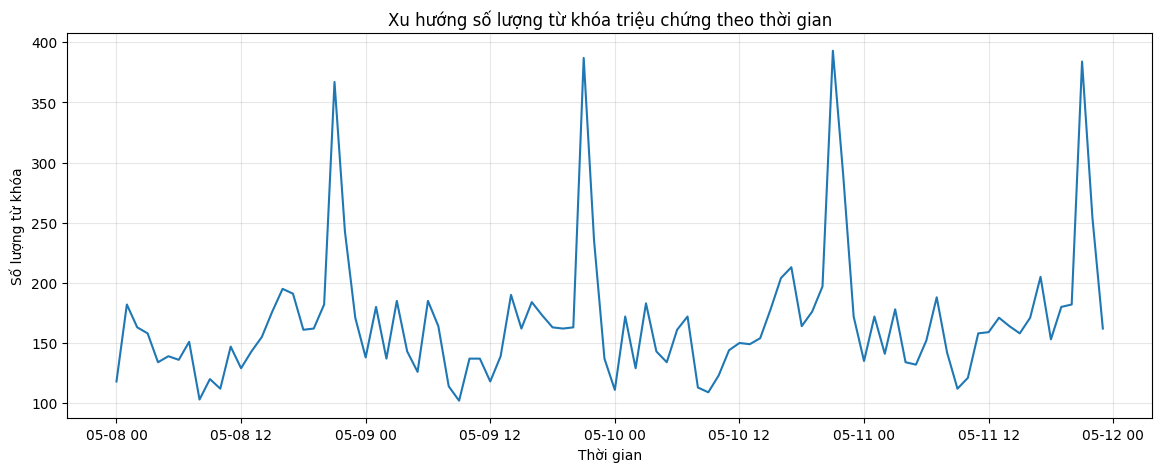

In [59]:
# Dòng này đảm bảo 100% cột timestamp là kiểu dữ liệu thời gian để Python có thể sắp xếp và nhóm đúng
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
# Gom số lượng từ khóa theo thời gian
# groupby là hàm dùng để gom các tgian cùng 1 cọc rồi đếm xem mốc tgian này có bao nhiêu keywords
trend = df_clean.groupby('timestamp')['count'].sum()
plt.figure(figsize=(14,5))
plt.plot(trend.index, trend.values)
plt.title("Xu hướng số lượng từ khóa triệu chứng theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Số lượng từ khóa")
plt.grid(alpha=0.3)
plt.savefig("../figures/Trend of Symptom Keyword Frequency Over Time.png", dpi=300, bbox_inches='tight')
plt.show()

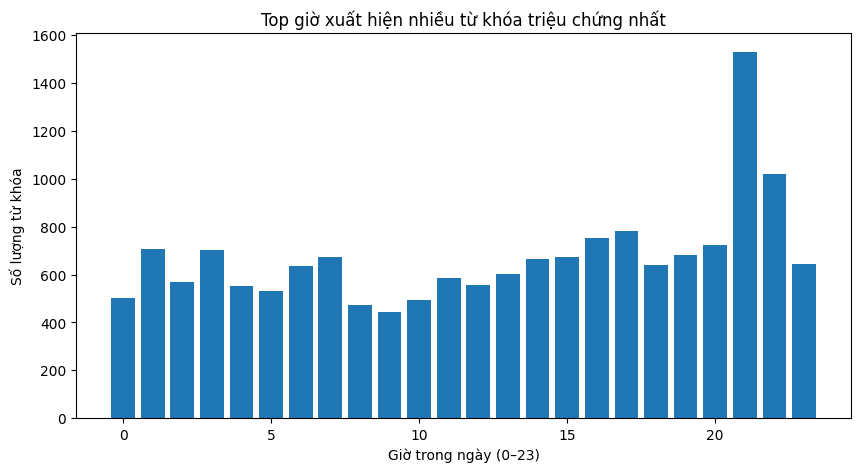

In [60]:
top_hours = df_clean.groupby(df_clean['timestamp'].dt.hour)['count'].sum()
plt.figure(figsize=(10,5))
plt.bar(top_hours.index, top_hours.values)
plt.title("Top giờ xuất hiện nhiều từ khóa triệu chứng nhất")
plt.xlabel("Giờ trong ngày (0–23)")
plt.ylabel("Số lượng từ khóa")
plt.savefig("../figures/top_hours_symptoms.png", dpi=300, bbox_inches='tight')
plt.show()

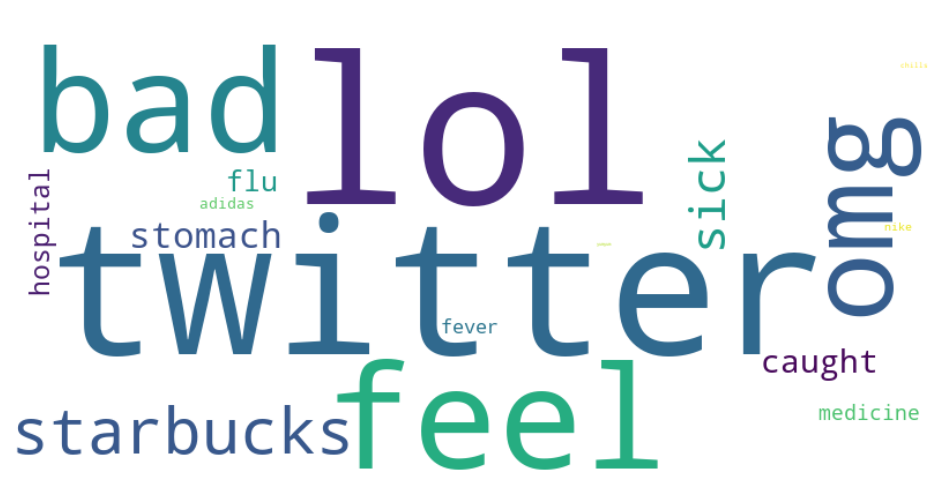

In [61]:
from wordcloud import WordCloud

word_freq = df_clean.groupby('keyword')['count'].sum().to_dict()

wc = WordCloud(width=800, height=400, background_color="white")
wc.generate_from_frequencies(word_freq)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("../figures/wordcloud_trieu_chung.png", dpi=300, bbox_inches='tight')
plt.show()

In [62]:
import pandas as pd
import numpy as np # Cần để sử dụng np.nan

# 1. Làm sạch chuỗi khỏi các ký tự list/tuple và khoảng trắng thừa
cleaned_locations = df_map['locations'].str.replace('[()]', '', regex=True) # Xóa các dấu ngoặc đơn/kép
cleaned_locations = cleaned_locations.str.replace('[\[\]]', '', regex=True) # Xóa các dấu ngoặc vuông
# Cột 'locations' của bạn giờ là chuỗi dạng '42.24071, 12.345' (hoặc '42.24071 12.345')
# 2. Tách chuỗi bằng dấu phẩy và khoảng trắng (để xử lý cả hai trường hợp)
# Sử dụng '[, ]+' để tách bằng 1 hoặc nhiều dấu phẩy HOẶC khoảng trắng
split_data = cleaned_locations.str.split(r'[, ]+', expand=True)
# 3. Gán kết quả vào 'lat' và 'lon' (kiểm tra lại tên cột)
# Đảm bảo rằng bạn chỉ lấy 2 cột đầu tiên nếu có nhiều hơn 2
if split_data.shape[1] >= 2:
    df_map['lat'] = pd.to_numeric(split_data[0], errors='coerce')
    df_map['lon'] = pd.to_numeric(split_data[1], errors='coerce')
else:
    # Xử lý trường hợp không có đủ 2 giá trị sau khi tách
    print("Cảnh báo: Không đủ dữ liệu lat/lon sau khi làm sạch và tách.")
    df_map['lat'] = np.nan
    df_map['lon'] = np.nan
# Các giá trị không thể chuyển thành float sẽ tự động là NaN (Not a Number)

Đang vẽ bản đồ tại khung giờ cao điểm nhất: 2011-05-10 09:00:00
Số lượng từ khóa xuất hiện trong giờ này: 15


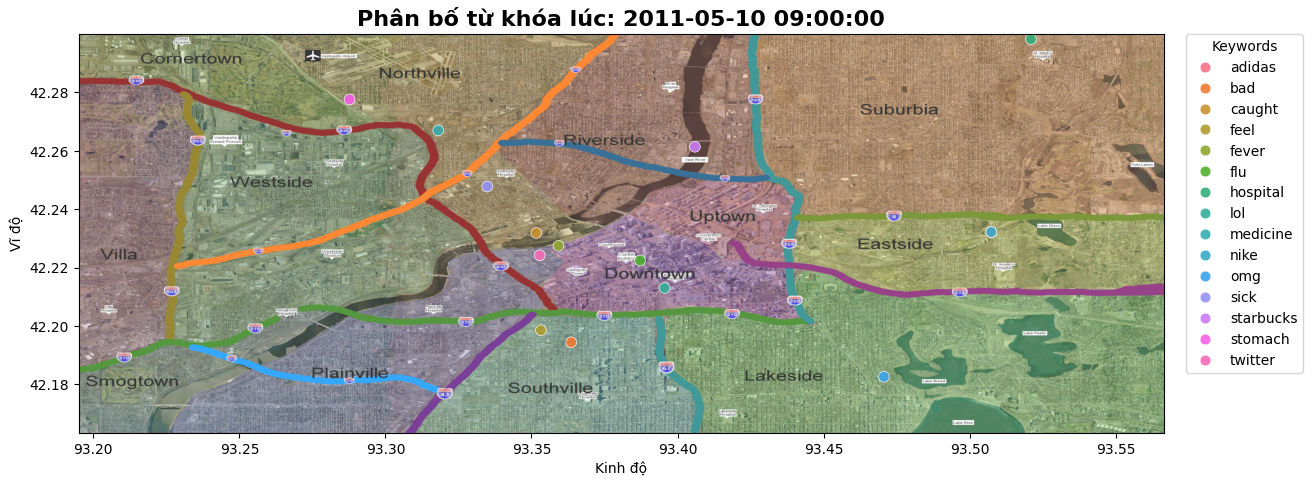

In [63]:

# ==========================================
# 1. CHỌN KHUNG GIỜ MUỐN VẼ
# ==========================================
# Để kiểm tra code, ta nên chọn khung giờ có NHIỀU dữ liệu nhất để bản đồ hiển thị rõ.
# Tìm giờ có số lượng bài viết nhiều nhất:
peak_hour = df_map.groupby('timestamp').size().idxmax()
print(f"Đang vẽ bản đồ tại khung giờ cao điểm nhất: {peak_hour}")

# Lọc dữ liệu chỉ lấy khung giờ này
df_plot = df_map[df_map['timestamp'] == peak_hour]

# (Tùy chọn) Nếu bạn muốn vẽ TẤT CẢ dữ liệu gộp lại (không chia giờ), hãy comment dòng trên và dùng:
# df_plot = df_map.copy() 
# ==========================================
# 2. XỬ LÝ MÀU SẮC CHO TỪ KHÓA
# ==========================================
# Lấy danh sách các từ khóa xuất hiện trong khung giờ này
keywords_in_frame = sorted(df_plot['keyword'].unique())
num_colors = len(keywords_in_frame)
print(f"Số lượng từ khóa xuất hiện trong giờ này: {num_colors}")
# Tạo bảng màu động (mỗi từ 1 màu)
# Dùng hệ màu 'husl' hoặc 'tab20' để các màu tách biệt nhau rõ nhất
palette = sns.color_palette("husl", num_colors) 
color_mapping = dict(zip(keywords_in_frame, palette))
# ==========================================
# 3. VẼ BẢN ĐỒ
# ==========================================
plt.figure(figsize=(14, 10)) # Để hình to cho dễ nhìn

# a) Vẽ nền bản đồ Vastopolis
map_img = plt.imread("../data/raw/Vastopolis_Map.png")
# Thay toạ độ thực của bạn vào đây (Lấy từ README.DOC)
vast_extent = [df_map['lon'].min(), df_map['lon'].max(), df_map['lat'].min(), df_map['lat'].max()]
plt.imshow(
    map_img, 
    extent=vast_extent, 
    alpha=0.8
)
# b) Vẽ các chấm màu (Scatterplot)
# hue='keyword': Tự động tô màu khác nhau cho từ khóa khác nhau
sns.scatterplot(
    data=df_plot,
    x='lon', 
    y='lat',
    hue='keyword',       # Yếu tố quyết định màu sắc
    palette=color_mapping, # Bảng màu đã tạo ở trên
    s=60,                # Kích thước chấm
    alpha=0.9,           # Độ đậm
    edgecolor='white',   # Viền trắng
    linewidth=0.5
)
# ==========================================
# 4. TRANG TRÍ & CHÚ THÍCH
# ==========================================
plt.title(f"Phân bố từ khóa lúc: {peak_hour}", fontsize=16, fontweight='bold')
plt.xlabel("Kinh độ")
plt.ylabel("Vĩ độ")
# Đưa bảng chú thích (Legend) ra ngoài biểu đồ
# Nếu có quá nhiều từ khóa, ta chia cột cho Legend
ncol_legend = 1
if num_colors > 15: ncol_legend = 2 # Nếu >15 từ thì chia 2 cột

plt.legend(
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0, 
    title="Keywords",
    ncol=ncol_legend
)
# Lưu hình
plt.savefig("../figures/keyword_map_single_hour.png", dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# ==========================================
# 0. CHUẨN BỊ DỮ LIỆU THỜI TIẾT (ĐÃ SỬA LỖI)
# ==========================================

# 1. Kiểm tra xem cột chứa giờ tên là gì (thường là 'Time' hoặc 'time')
# In ra để bạn kiểm tra tên cột thực tế
print("Các cột trong bảng Weather:", weather.columns)

# 2. Tạo cột timestamp
# Trường hợp phổ biến nhất: Bảng có cột 'date' và cột 'Time' (ví dụ: '14:00' hoặc '2:00 PM')
try:
    if 'Time' in weather.columns:
        # Nối ngày và giờ
        weather['timestamp'] = pd.to_datetime(weather['date'] + ' ' + weather['Time'])
    elif 'time' in weather.columns:
        weather['timestamp'] = pd.to_datetime(weather['date'] + ' ' + weather['time'])
    else:
        print("LỖI: Không tìm thấy cột giờ (Time/time) trong bảng weather!")
        # Dừng chương trình hoặc kiểm tra lại tên cột thủ công
except Exception as e:
    print(f"Lỗi khi chuyển đổi thời gian: {e}")

# 3. Làm tròn về đầu giờ (QUAN TRỌNG)
# Vì vòng lặp vẽ bản đồ đang chạy theo từng giờ chẵn (floor('H')), 
# nên weather cũng phải làm tròn để khớp nhau.
if 'timestamp' in weather.columns:
    weather['timestamp'] = weather['timestamp'].dt.floor('H')
    print("Đã tạo thành công cột timestamp cho Weather!")
    print(weather[['timestamp', 'wind_direction', 'average_wind_speed']].head())

Các cột trong bảng Weather: Index(['Date', 'Weather', 'Average_Wind_Speed', 'Wind_Direction',
       'date_invalid', 'Parsed_Date', 'weather_empty', 'weather_invalid',
       'wind_speed_invalid', 'wind_speed_missing', 'wind_speed_negative',
       'wind_dir_invalid'],
      dtype='object')
LỖI: Không tìm thấy cột giờ (Time/time) trong bảng weather!


In [65]:
# ==========================================
# 0. CHUẨN BỊ DỮ LIỆU THỜI TIẾT (FIX LỖI DAILY -> HOURLY)
# ==========================================

print("Đang xử lý nội suy (Upsampling) thời tiết từ Ngày sang Giờ...")

# 1. Chuyển cột 'Date' sang dạng datetime chuẩn
weather['Date'] = pd.to_datetime(weather['Date'])

# 2. Loại bỏ các dòng trùng lặp nếu có (giữ dòng đầu tiên)
weather = weather.drop_duplicates(subset=['Date'])

# 3. Đặt 'Date' làm chỉ mục (Index) để thực hiện Resample
weather = weather.set_index('Date')

# 4. Thực hiện Upsampling (Nội suy)
# 'H': Chuyển đổi sang tần suất theo Giờ
# .ffill(): Forward Fill - Lấy giá trị của 00:00 điền cho 01:00, 02:00... đến hết ngày
# (Giả định gió không đổi trong ngày, hoặc bạn có thể dùng .interpolate() nếu muốn số liệu mượt hơn)
weather_hourly = weather.resample('H').ffill()

# 5. Reset index để lấy lại cột timestamp
weather_hourly = weather_hourly.reset_index()

# Đổi tên cột 'Date' thành 'timestamp' để khớp với code vẽ biểu đồ
weather_hourly.rename(columns={'Date': 'timestamp'}, inplace=True)

# Đổi tên các cột thông số cho dễ gọi (về chữ thường)
weather_hourly.rename(columns={
    'Average_Wind_Speed': 'average_wind_speed', 
    'Wind_Direction': 'wind_direction'
}, inplace=True)

print("Đã xử lý xong! Dữ liệu weather bây giờ có dạng theo giờ:")
print(weather_hourly[['timestamp', 'wind_direction', 'average_wind_speed']].head())

# Gán ngược lại vào biến weather để dùng cho đoạn code vẽ GIF bên dưới
weather = weather_hourly

Đang xử lý nội suy (Upsampling) thời tiết từ Ngày sang Giờ...
Đã xử lý xong! Dữ liệu weather bây giờ có dạng theo giờ:
            timestamp wind_direction  average_wind_speed
0 2011-04-30 00:00:00              E                   9
1 2011-04-30 01:00:00              E                   9
2 2011-04-30 02:00:00              E                   9
3 2011-04-30 03:00:00              E                   9
4 2011-04-30 04:00:00              E                   9


In [66]:
# ==========================================
# BƯỚC SỬA LỖI: ÉP KIỂU SỐ CHO DỮ LIỆU GIÓ
# ==========================================

print("Đang kiểm tra và sửa lỗi dữ liệu gió...")

# 1. Ép kiểu sang số (float). Nếu gặp lỗi (ví dụ dòng trống hoặc chữ lạ), biến thành NaN
weather['wind_direction'] = pd.to_numeric(weather['wind_direction'], errors='coerce')
weather['average_wind_speed'] = pd.to_numeric(weather['average_wind_speed'], errors='coerce')

# 2. Kiểm tra lại xem có dòng nào bị NaN (Not a Number) không
# (Nếu dữ liệu gốc có chỗ bị lỗi, bước trên sẽ tạo ra NaN)
missing_data = weather[['wind_direction', 'average_wind_speed']].isnull().sum()
print(f"Số lượng dữ liệu gió bị lỗi/trống: \n{missing_data}")

# 3. Điền dữ liệu còn thiếu (nếu có) bằng phương pháp 'ffill' (lấy giá trị giờ trước điền vào)
weather['wind_direction'] = weather['wind_direction'].ffill().bfill()
weather['average_wind_speed'] = weather['average_wind_speed'].ffill().bfill()

print("Đã chuyển đổi xong cột gió sang dạng số!")
print(weather[['timestamp', 'wind_direction', 'average_wind_speed']].dtypes)

Đang kiểm tra và sửa lỗi dữ liệu gió...
Số lượng dữ liệu gió bị lỗi/trống: 
wind_direction        481
average_wind_speed      0
dtype: int64
Đã chuyển đổi xong cột gió sang dạng số!
timestamp             datetime64[ns]
wind_direction               float64
average_wind_speed             int64
dtype: object


In [67]:
import matplotlib
matplotlib.use('Agg') # FIX 1: Chạy ngầm để tiết kiệm RAM
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio
import os
import pandas as pd
import numpy as np # Cần thêm thư viện này để tính sin/cos
import gc # FIX 2: Thư viện dọn rác

# ==========================================
# 0. CHUẨN BỊ DỮ LIỆU THỜI TIẾT
# ==========================================
# Giả sử bạn đã load bảng weather.csv vào biến 'weather'
# Cần đảm bảo cột timestamp của weather đã được chuyển về dạng datetime chuẩn
if 'timestamp' not in weather.columns:
    # Code dự phòng nếu chưa có cột timestamp
    weather['timestamp'] = pd.to_datetime(weather['Date'] + ' ' + weather['hour'].astype(str) + ':00')

# ==========================================
# 1. THIẾT LẬP
# ==========================================
frame_dir = "../figures/frames_wind_temp/" # Đổi tên folder tạm để tránh lẫn lộn
os.makedirs(frame_dir, exist_ok=True)
gif_output_path = "../figures/epidemic_spread_with_wind.gif"

# Đọc ảnh nền
map_img = plt.imread("../data/raw/Vastopolis_Map.png")

# TỌA ĐỘ (Thay bằng số thực tế của bạn)
vast_extent = [df_map['lon'].min(), df_map['lon'].max(), df_map['lat'].min(), df_map['lat'].max()]

# ==========================================
# 2. VÒNG LẶP VẼ HÌNH
# ==========================================
# Gom nhóm theo giờ
grouped_by_hour = df_map.groupby(df_map['timestamp'].dt.floor('H'))
filenames = []

print("Đang tạo frames có kèm hướng gió...")

for i, (hour_timestamp, df_hour) in enumerate(grouped_by_hour):
    
    # Chỉ vẽ nếu có dữ liệu > 5 điểm để tránh lỗi
    if len(df_hour) > 5:
        fig, ax = plt.subplots(figsize=(8, 8)) 
        
        # a) Vẽ nền bản đồ
        ax.imshow(map_img, extent=vast_extent, alpha=0.8)
        
        # b) Vẽ Heatmap dịch bệnh
        try:
            sns.kdeplot(
                x=df_hour['lon'],
                y=df_hour['lat'],
                fill=True,
                alpha=0.6,
                cmap='Spectral_r', # Màu đỏ là nóng
                levels=10, 
                thresh=0.05,
                ax=ax
            )
        except Exception as e:
            plt.close(fig)
            continue

        # ---------------------------------------------------------
        # --- MỚI: TÍNH TOÁN VÀ VẼ GIÓ (WIND VECTOR) ---
        # ---------------------------------------------------------
        try:
            # 1. Tìm dòng thời tiết ứng với giờ hiện tại
            current_weather = weather[weather['timestamp'] == hour_timestamp]
            
            if not current_weather.empty:
                # Lấy hướng gió (độ) và tốc độ
                wind_dir = current_weather['wind_direction'].values[0]
                wind_speed = current_weather['average_wind_speed'].values[0]
                
                # 2. Tính toán Vector (U, V)
                # Lưu ý: Gió thổi TỪ hướng wind_dir -> Mũi tên chỉ NGƯỢC LẠI
                # Công thức chuyển độ sang radian và tính vector
                wind_rad = np.radians(wind_dir)
                U = -wind_speed * np.sin(wind_rad)
                V = -wind_speed * np.cos(wind_rad)
                
                # 3. Xác định vị trí đặt mũi tên (Góc trên bên trái bản đồ)
                # Tự động tính toán dựa trên vast_extent (khoảng 10% từ lề trái, 90% từ lề dưới)
                arrow_x = vast_extent[0] + (vast_extent[1] - vast_extent[0]) * 0.15
                arrow_y = vast_extent[2] + (vast_extent[3] - vast_extent[2]) * 0.90
                
                # 4. Vẽ mũi tên bằng ax.quiver
                ax.quiver(
                    arrow_x, arrow_y, 
                    U, V, 
                    color='black', # Màu mũi tên (đen cho nổi trên nền sáng, hoặc trắng nếu nền tối)
                    scale=50,      # ĐIỀU CHỈNH SỐ NÀY: Số càng to mũi tên càng ngắn
                    width=0.02,    # Độ dày thân mũi tên
                    headwidth=5,   # Độ rộng đầu mũi tên
                    zorder=10      # Đảm bảo mũi tên nằm đè lên trên heatmap
                )
                
                # 5. Thêm chữ chú thích tốc độ gió
                ax.text(
                    arrow_x, arrow_y - 0.04, # Đặt chữ nằm dưới mũi tên một chút
                    f"Gió: {wind_speed} m/s", 
                    fontsize=12, fontweight='bold', color='black', ha='center'
                )
        except Exception as e:
            print(f"Lỗi vẽ gió tại {hour_timestamp}: {e}")
            pass # Nếu lỗi vẽ gió thì vẫn vẽ bản đồ bình thường

        # ---------------------------------------------------------
        
        # c) Trang trí
        time_str = hour_timestamp.strftime('%Y-%m-%d %H:%M')
        ax.set_title(f"Diễn biến dịch & Hướng gió: {time_str}", fontsize=14, fontweight='bold')
        ax.set_xlim(vast_extent[0], vast_extent[1])
        ax.set_ylim(vast_extent[2], vast_extent[3])
        ax.axis('off')

        filename = os.path.join(frame_dir, f"frame_{i:03d}.png")
        
        plt.savefig(filename, dpi=72, bbox_inches='tight') 
        filenames.append(filename)
        
        plt.close(fig)
        gc.collect() 
        
        if (i + 1) % 10 == 0:
            print(f"Đã xong {i + 1} khung hình...")

# --- 3. GHÉP GIF ---
print("Đang ghép GIF...")
with imageio.get_writer(gif_output_path, mode='I', duration=0.5) as writer: # Chỉnh 0.5 để chạy chậm dễ nhìn
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Dọn dẹp
for filename in filenames:
    try:
        os.remove(filename)
    except: pass
try:
    os.rmdir(frame_dir)
except: pass

print(f"Xong! File lưu tại: {gif_output_path}")

Đang tạo frames có kèm hướng gió...
Đã xong 10 khung hình...
Đã xong 20 khung hình...
Đã xong 30 khung hình...
Đã xong 40 khung hình...
Đã xong 50 khung hình...
Đã xong 60 khung hình...
Đã xong 70 khung hình...
Đã xong 80 khung hình...
Đã xong 90 khung hình...
Đang ghép GIF...
Xong! File lưu tại: ../figures/epidemic_spread_with_wind.gif
